# Vector Representations of Documents

http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

Based on:

https://www.tensorflow.org/tutorials/word2vec

In [1]:
import tensorflow as tf
tf.__version__

'1.2.0'

In [2]:
import os
import re
import zipfile
import shutil

HOME_DIR = 'rotten_tomatoes'
DATA_DIR = os.path.join(HOME_DIR, 'data')

print('Unpacking Stanford Sentiment Treebank dataset...')

PKG_FILE = 'stanfordSentimentTreebank.zip'
PKG_PATH = os.path.join(DATA_DIR, PKG_FILE)

from tensorflow.contrib.learn.python.learn.datasets.base import maybe_download
maybe_download(PKG_FILE, DATA_DIR, 'http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip')

DATAFILE_PATTERN = re.compile(r'^stanfordSentimentTreebank/.+\.txt$')

def extract(zip_file, filename, dst_path):
    print('Extracting', filename)
    dst_file = os.path.join(dst_path, os.path.basename(filename))
    with open(dst_file, 'wb') as fout:
        fin = zip_file.open(filename)
        shutil.copyfileobj(fin, fout)

with zipfile.ZipFile(PKG_PATH) as f:
    files = [name for name in f.namelist() if DATAFILE_PATTERN.match(name)]
    for filename in files:
        extract(f, filename, DATA_DIR)

Unpacking Stanford Sentiment Treebank dataset...
Extracting stanfordSentimentTreebank/datasetSentences.txt
Extracting stanfordSentimentTreebank/datasetSplit.txt
Extracting stanfordSentimentTreebank/dictionary.txt
Extracting stanfordSentimentTreebank/original_rt_snippets.txt
Extracting stanfordSentimentTreebank/README.txt
Extracting stanfordSentimentTreebank/sentiment_labels.txt
Extracting stanfordSentimentTreebank/SOStr.txt
Extracting stanfordSentimentTreebank/STree.txt


In [3]:
def show(filename, n=10):
    with open(filename) as f:
        for _ in range(n):
            print(next(f).strip())

In [4]:
SENTENCES_FILE = os.path.join(DATA_DIR, 'datasetSentences.txt')
show(SENTENCES_FILE)

sentence_index	sentence
1	The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
2	The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .
3	Effective but too-tepid biopic
4	If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .
5	Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .
6	The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
7	Offers that rare combination of entertainment and education .
8	Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .
9	Ste

In [5]:
PHRASES_FILE = os.path.join(DATA_DIR, 'dictionary.txt')
show(PHRASES_FILE)

!|0
! '|22935
! ''|18235
! Alas|179257
! Brilliant|22936
! Brilliant !|40532
! Brilliant ! '|22937
! C'mon|60624
! Gollum 's ` performance ' is incredible|13402
! Oh , look at that clever angle ! Wow , a jump cut !|179258


In [6]:
LABELS_FILE = os.path.join(DATA_DIR, 'sentiment_labels.txt')
show(LABELS_FILE)

phrase ids|sentiment values
0|0.5
1|0.5
2|0.44444
3|0.5
4|0.42708
5|0.375
6|0.41667
7|0.54167
8|0.33333


In [7]:
SPLIT_FILE = os.path.join(DATA_DIR, 'datasetSplit.txt')
show(SPLIT_FILE)

sentence_index,splitset_label
1,1
2,1
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [8]:
sentences = dict()

def text_fix(txt):
    if '-LRB-' in txt:
        txt = txt.replace('-LRB-', '(')
    if '-RRB-' in txt:
        txt = txt.replace('-RRB-', ')')
    if 'Ã¡' in txt:
        txt = txt.replace('Ã¡', 'á')
    if 'Ã ' in txt:
        txt = txt.replace('Ã ', 'à')
    if 'Ã¢' in txt:
        txt = txt.replace('Ã¢', 'â')
    if 'Ã£' in txt:
        txt = txt.replace('Ã£', 'ã')
    if 'Ã©' in txt:
        txt = txt.replace('Ã©', 'é')
    if 'Ã¨' in txt:
        txt = txt.replace('Ã¨', 'è')
    if 'Ã­' in txt:
        txt = txt.replace('Ã­', 'í')
    if 'Ã¯' in txt:
        txt = txt.replace('Ã¯', 'ï')
    if 'Ã³' in txt:
        txt = txt.replace('Ã³', 'ó')
    if 'Ã´' in txt:
        txt = txt.replace('Ã´', 'ô')
    if 'Ã¶' in txt:
        txt = txt.replace('Ã¶', 'ö')
    if 'Ã»' in txt:
        txt = txt.replace('Ã»', 'û')
    if 'Ã¼' in txt:
        txt = txt.replace('Ã¼', 'ü')
    if 'Ã¦' in txt:
        txt = txt.replace('Ã¦', 'æ')
    if 'Ã§' in txt:
        txt = txt.replace('Ã§', 'ç')
    if 'Ã±' in txt:
        txt = txt.replace('Ã±', 'ñ')
    if '2Â' in txt:
        txt = txt.replace('2Â', '2')
    if '8Â' in txt:
        txt = txt.replace('8Â', '8')
    return txt

with open(SENTENCES_FILE) as f:
    f.readline() # skip header
    while True:
        line = f.readline()
        if not line:
            break
        idx, txt = line.rstrip().split('\t')
        sentences[idx] = text_fix(txt)

print("Sentences:", len(sentences))

Sentences: 11855


In [9]:
phrases = dict()

with open(PHRASES_FILE) as f:
    while True:
        line = f.readline()
        if not line:
            break
        txt, idx = line.rstrip().split('|')
        phrases[txt] = idx

print("Phrases:", len(phrases))

Phrases: 239232


In [10]:
labels = dict()

with open(LABELS_FILE) as f:
    f.readline() # skip header
    while True:
        line = f.readline()
        if not line:
            break
        idx, score = line.rstrip().split('|')
        labels[idx] = float(score)

print("Labels:", len(labels))

Labels: 239232


In [11]:
n = 0
for txt in sentences.values():
    if txt not in phrases:
        print('Missing:', txt)
        n += 1

print('Total missing:', n)

Total missing: 0


In [12]:
# %%time

# sentence_phrases = {s: list() for s in sentences.keys()}
# phrases_count = {phrase: 0 for phrase in phrases.keys()}

# for phrase, p in phrases.iteritems():
#     n = 0
#     for s, txt in sentences.iteritems():
#         if phrase in txt:
#             sentence_phrases[s].append(p)
#             n += 1
#     phrases_count[phrase] = n

In [13]:
# top_phrases = sorted(phrases_count.items(), key=lambda i: i[1], reverse=True)
# top_phrases[0:30]

In [14]:
# top_sentences = sorted(sentence_phrases.items(), key=lambda i: len(i[1]), reverse=True)
# [(s, len(p)) for s, p in top_sentences[0:30]]

In [15]:
train = list()
valid = list()
test = list()

splits = {
    '1': train,
    '2': test,
    '3': valid,
}

with open(SPLIT_FILE) as f:
    f.readline() # skip header
    while True:
        line = f.readline()
        if not line:
            break
        idx, split = line.rstrip().split(',')
        splits[split].append(idx)

print('Train sentences:', len(train))
print('Test sentences:', len(test))
print('Validation sentences:', len(valid))

Train sentences: 8544
Test sentences: 2210
Validation sentences: 1101


## Word2vec

In [16]:
def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9(),!?\'\`]', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text.strip().lower()

def words(sentences_list):
    return ' '.join(clean_text(sentences[s]) for s in sentences_list).split()

words(train[0:1])

['the',
 'rock',
 'is',
 'destined',
 'to',
 'be',
 'the',
 '21st',
 'century',
 "'s",
 'new',
 '``',
 'conan',
 "''",
 'and',
 'that',
 'he',
 "'s",
 'going',
 'to',
 'make',
 'a',
 'splash',
 'even',
 'greater',
 'than',
 'arnold',
 'schwarzenegger',
 ',',
 'jean',
 'claud',
 'van',
 'damme',
 'or',
 'steven',
 'segal']

In [17]:
import collections

VOCABULARY_SIZE = 50000

class WordCorpus:
    
    def __init__(self, words, vocabulary_size = VOCABULARY_SIZE):
        corpus_words = collections.Counter(words).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(corpus_words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        data = list()
        unk_count = 0
        
        for word in words:
            index = word_to_idx.get(word, 0) # 0 = UNK
            if index == 0:
                unk_count += 1
            data.append(index)

        corpus_words.insert(0, ('UNK', unk_count))

        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        self.data = data
        self.words = sorted(corpus_words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    def most_common(self, n=5):
        return self.words[:n]
    
    def sample_ids(self, start=0, n=10):
        return self.data[start:(start + n)]

    def sample_words(self, start=0, n=10):
        return [self.word_from_idx(i) for i in self.sample_ids(start, n)]

    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]
    
train_data = WordCorpus(words(train))

print('Vocabulary size:\n')
print(train_data.vocabulary_size)
print('\nMost common words (+UNK):\n')
print(train_data.most_common())
print('\nSample data:\n')
print(train_data.sample_ids(), '\n')
print(train_data.sample_words())

Vocabulary size:

15338

Most common words (+UNK):

[('the', 7353), (',', 7131), ('a', 5313), ('and', 4521), ('of', 4456)]

Sample data:

[1, 536, 7, 3552, 6, 23, 1, 2936, 945, 8] 

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s"]


In [18]:
import numpy as np

class BatchGenerator:
    
    def __init__(self, data, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.data = data
        self.data_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        for _ in range(self.window_size):
            self.window_forward()

    def window_forward(self):
        self.window.append(self.data[self.data_index])
        self.data_index = (self.data_index + 1) % len(self.data)

    def read(self):
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)

        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return batch, labels

data_reader = BatchGenerator(train_data.data, batch_size=8, num_skips=2, skip_window=1)

print('1st Batch:\n')
batch, labels = data_reader.read()
for i in range(len(batch)):
    print('{} {} -> {} {}'.format(batch[i],
                                  train_data.word_from_idx(batch[i]),
                                  labels[i, 0],
                                  train_data.word_from_idx(labels[i, 0])))

print('\n2nd Batch:\n')
batch, labels = data_reader.read()
for i in range(len(batch)):
    print('{} {} -> {} {}'.format(batch[i],
                                  train_data.word_from_idx(batch[i]),
                                  labels[i, 0],
                                  train_data.word_from_idx(labels[i, 0])))

1st Batch:

536 rock -> 1 the
536 rock -> 7 is
7 is -> 3552 destined
7 is -> 536 rock
3552 destined -> 7 is
3552 destined -> 6 to
6 to -> 23 be
6 to -> 3552 destined

2nd Batch:

23 be -> 6 to
23 be -> 1 the
1 the -> 23 be
1 the -> 2936 21st
2936 21st -> 945 century
2936 21st -> 1 the
945 century -> 2936 21st
945 century -> 8 's


In [19]:
import os
import shutil

class Word2vecModel:
    
    #vocabulary_size
    #embedding_size
    #num_sampled
    
    #input_data
    #input_labels
    #loss
    #optimizer
    #embeddings
    #similarity
    
    def __init__(self,
                 vocabulary_size,
                 embedding_size,
                 num_sampled):
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        
        self.build_graph()
    
    def build_graph(self):
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -1.0,
                1.0))
        embed = tf.nn.embedding_lookup(embeddings, self.input_data)

        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, self.embedding_size],
                stddev=1.0 / np.sqrt(self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)

        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        self.embeddings = embeddings / norm


class NearestWordsQuery:
    
    def __init__(self, embeddings, mapping, words, k=4):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(words_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class Word2vecTrainer:
    
    #corpus
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 logdir='log/word2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.logdir = logdir
    
    def remove_log(self):
        if os.path.isdir(self.logdir):
            shutil.rmtree(self.logdir)
    
    def train(self, num_steps=100001, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.optimizer, model.loss]
                average_loss = 0

                for step in range(num_steps):
                    batch_data, batch_labels = data_reader.read()
                    feed_dict = {model.input_data: batch_data, model.input_labels: batch_labels}

                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 2000 == 0:
                        if step > 0:
                            average_loss /= 2000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0

                    if step % 10000 == 0:
                        print()
                        word_query.run(session)
                        print()

                words_embeddings = session.run(model.embeddings)
        
        return words_embeddings
    
    def data_reader(self):
        return BatchGenerator(self.corpus.data, self.batch_size, self.num_skips, self.skip_window)

    def build_model(self):
        return Word2vecModel(self.corpus.vocabulary_size, self.embedding_size, self.num_sampled)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model.embeddings, self.corpus, words)
        
    def sample_words(self, sample_size=16):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

In [20]:
%%time

trainer = Word2vecTrainer(
    train_data,
    batch_size = 128,
    skip_window = 1,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 128,  # Dimension of the embedding vector.
    num_sampled = 64)      # Number of negative examples to sample.

words_embeddings = trainer.train()

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path log/word2vec/model.ckpt
INFO:tensorflow:Starting queue runners.
Average loss at step 0: 228.454

Nearest to artworks: arguments (0.370), africa (0.351), chicken (0.312), biblical (0.311)
Nearest to mexican: stylishly (0.338), orbits (0.316), speaks (0.304), whining (0.299)
Nearest to give: lousy (0.344), unfaithful (0.311), breach (0.294), twentysomething (0.293)
Nearest to ghost: pool (0.334), demanding (0.309), uppity (0.297), freshening (0.294)
Nearest to setting: thematically (0.317), fetishes (0.304), rehearsed (0.296), andr (0.290)
Nearest to plumbs: transcends (0.338), prevalent (0.334), responsible (0.329), fallibility (0.325)
Nearest to lying: rowling (0.340), feat (0.320), point (0.318), ownership (0.311)
Nearest to savvy: perfectly (0.345), coasting (0.328), candor (0.315), half (0.313)
Nearest to lasting: retitle (0.343), favourite (0.327), caine (0.304), dichotomy (0.302)
Nearest to const

Average loss at step 52,000: 3.762
Average loss at step 54,000: 3.737
Average loss at step 56,000: 3.729
Average loss at step 58,000: 3.713
Average loss at step 60,000: 3.693

Nearest to artworks: arguments (0.471), africa (0.438), biblical (0.417), unequivocally (0.416)
Nearest to mexican: whining (0.428), stylishly (0.426), orbits (0.413), speaks (0.406)
Nearest to give: leave (0.454), jaglomized (0.418), buffs (0.416), conduct (0.408)
Nearest to ghost: pool (0.437), freshening (0.428), demanding (0.419), geddes (0.416)
Nearest to setting: thematically (0.426), kids (0.420), rehearsed (0.415), cycle (0.401)
Nearest to plumbs: prevalent (0.439), transcends (0.427), responsible (0.420), fallibility (0.418)
Nearest to lying: rowling (0.453), point (0.448), visible (0.441), ownership (0.429)
Nearest to savvy: coasting (0.445), heal (0.428), perfectly (0.417), as (0.410)
Nearest to lasting: retitle (0.456), dichotomy (0.432), favourite (0.432), caine (0.427)
Nearest to constraints: bytes 

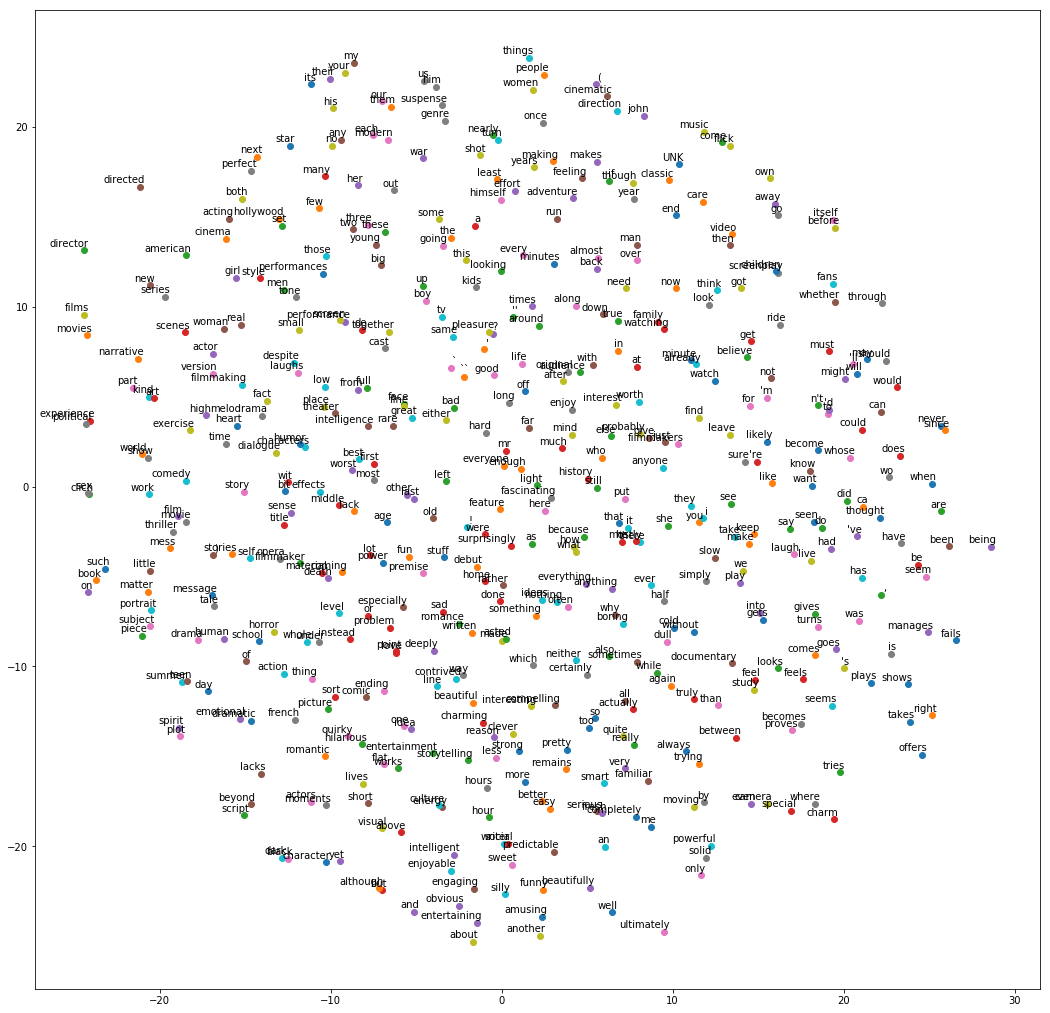

In [21]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(words_embeddings[:plot_only,:])
labels = list(train_data.word_from_idx(i) for i in range(plot_only))

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

plt.show()

## Paragraph2vec

In [22]:
for i, s in enumerate(sentences.items()):
    if i == 10:
        break
    print('{}\n\n{}\n'.format(*s))

1

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .

2

The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .

3

Effective but too-tepid biopic

4

If you sometimes like to go to the movies to have fun , Wasabi is a good place to start .

5

Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .

6

The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

7

Offers that rare combination of entertainment and education .

8

Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions .

9

Steers tur

In [23]:
train[:10]

['1', '2', '61', '62', '63', '64', '68', '72', '82', '131']

In [24]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, document_ids, vocabulary_size=VOCABULARY_SIZE):
        documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        
        self.documents = documents
        
        documents_words = dict((doc_id, clean_text(doc_raw).split())
                               for doc_id, doc_raw in documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_corpus = DocumentCorpus(sentences, train)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example:', train[0], '\n')
print(train_corpus.raw_from_id(train[0]), '\n')
print(train_corpus.vector_form_id(train[0]), '\n')
print(train_corpus.vector_form_id_words(train[0]))

Vocabulary size:

15338

Documents size:

8544

Most common words (+UNK):

[('the', 7353), (',', 7131), ('a', 5313), ('and', 4521), ('of', 4456)]

Document example: 1 

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal . 

[1, 536, 7, 3552, 6, 23, 1, 2936, 945, 8, 105, 61, 5691, 62, 4, 10, 73, 8, 266, 6, 81, 3, 4374, 64, 3553, 36, 1968, 2937, 2, 2938, 8235, 1772, 5692, 43, 889, 8236] 

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', "'s", 'new', '``', 'conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal']


In [25]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            self.document_index = (self.document_index + 1) % len(self.document_vectors)
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (536, rock) -> (7, is)
0: (536, rock) -> (1, the)
0: (7, is) -> (3552, destined)
0: (7, is) -> (536, rock)
0: (3552, destined) -> (6, to)
0: (3552, destined) -> (7, is)
0: (6, to) -> (23, be)
0: (6, to) -> (3552, destined)
0: (23, be) -> (1, the)
0: (23, be) -> (6, to)

2nd Batch:

0: (1, the) -> (23, be)
0: (1, the) -> (2936, 21st)
0: (2936, 21st) -> (1, the)
0: (2936, 21st) -> (945, century)
0: (945, century) -> (2936, 21st)
0: (945, century) -> (8, 's)
0: (8, 's) -> (945, century)
0: (8, 's) -> (105, new)
0: (105, new) -> (8, 's)
0: (105, new) -> (61, ``)

3rd Batch:

0: (61, ``) -> (105, new)
0: (61, ``) -> (5691, conan)
0: (5691, conan) -> (61, ``)
0: (5691, conan) -> (62, '')
0: (62, '') -> (4, and)
0: (62, '') -> (5691, conan)
0: (4, and) -> (62, '')
0: (4, and) -> (10, that)
0: (10, that) -> (73, he)
0: (10, that) -> (4, and)


In [26]:
import os
import shutil

class Paragraph2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #optimizer
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -1.0,
                1.0))
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -1.0,
                1.0))
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self.optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(self.loss)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm


class NearestWordsQuery:
    
    def __init__(self, embeddings, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(words_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, embeddings, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_text = self.doc_from_idx(doc_idx)
            print('{}\n'.format(doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}'.format(n, near_sim, near_text))
            print('---\n')


class Paragraph2vecTrainer:
    
    #corpus
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 logdir='log/paragraph2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.logdir = logdir
    
    def remove_log(self):
        if os.path.isdir(self.logdir):
            shutil.rmtree(self.logdir)
    
    def train(self, num_steps=100001, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.optimizer, model.loss]
                average_loss = 0

                for step in range(num_steps):
                    batch_docs, batch_data, batch_labels = data_reader.read()
                    feed_dict = {
                        model.input_docs: batch_docs,
                        model.input_data: batch_data,
                        model.input_labels: batch_labels,
                    }

                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 2000 == 0:
                        if step > 0:
                            average_loss /= 2000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0

                    if step % 10000 == 0:
                        print()
                        doc_query.run(session)
                        word_query.run(session)
                        print()

                docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Paragraph2vecModel(self.corpus.documents_size,
                            self.corpus.vocabulary_size,
                            self.embedding_size,
                            self.num_sampled)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model.words_embeddings, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model.docs_embeddings, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)

In [27]:
%%time

doc_trainer = Paragraph2vecTrainer(
    train_corpus,
    batch_size = 128,
    skip_window = 1,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 128,  # Dimension of the embedding vector.
    num_sampled = 64)      # Number of negative examples to sample.

docs_embeddings = doc_trainer.train()

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path log/paragraph2vec/model.ckpt
INFO:tensorflow:Starting queue runners.
Average loss at step 0: 261.802

This wretchedly unfunny wannabe comedy is inane and awful - no doubt , it 's the worst movie I 've seen this summer .

[ 1, 0.308 ] Sewer rats could watch this movie and be so skeeved out that they 'd need a shower .
[ 2, 0.305 ] According to the script , Grant and Bullock 's characters are made for each other .
[ 3, 0.297 ] Straightforward and old-fashioned in the best possible senses of both those words , Possession is a movie that puts itself squarely in the service of the lovers who inhabit it .
---

The big-screen Scooby makes the silly original cartoon seem smart and well-crafted in comparison .

[ 1, 0.317 ] In a summer of clones , Harvard Man is something rare and riveting : a wild ride that relies on more than special effects .
[ 2, 0.306 ] The Woodman seems to have directly influenced this g

Average loss at step 42,000: 2.736
Average loss at step 44,000: 2.698
Average loss at step 46,000: 2.657
Average loss at step 48,000: 2.621
Average loss at step 50,000: 2.595

This wretchedly unfunny wannabe comedy is inane and awful - no doubt , it 's the worst movie I 've seen this summer .

[ 1, 0.348 ] ... flat-out amusing , sometimes endearing and often fabulous , with a solid cast , noteworthy characters , delicious dialogue and a wide supply of effective sight gags .
[ 2, 0.340 ] According to the script , Grant and Bullock 's characters are made for each other .
[ 3, 0.325 ] Sewer rats could watch this movie and be so skeeved out that they 'd need a shower .
---

The big-screen Scooby makes the silly original cartoon seem smart and well-crafted in comparison .

[ 1, 0.337 ] More vaudeville show than well-constructed narrative , but on those terms it 's inoffensive and actually rather sweet .
[ 2, 0.327 ] It 's weird , wonderful , and not necessarily for kids .
[ 3, 0.293 ] Becom

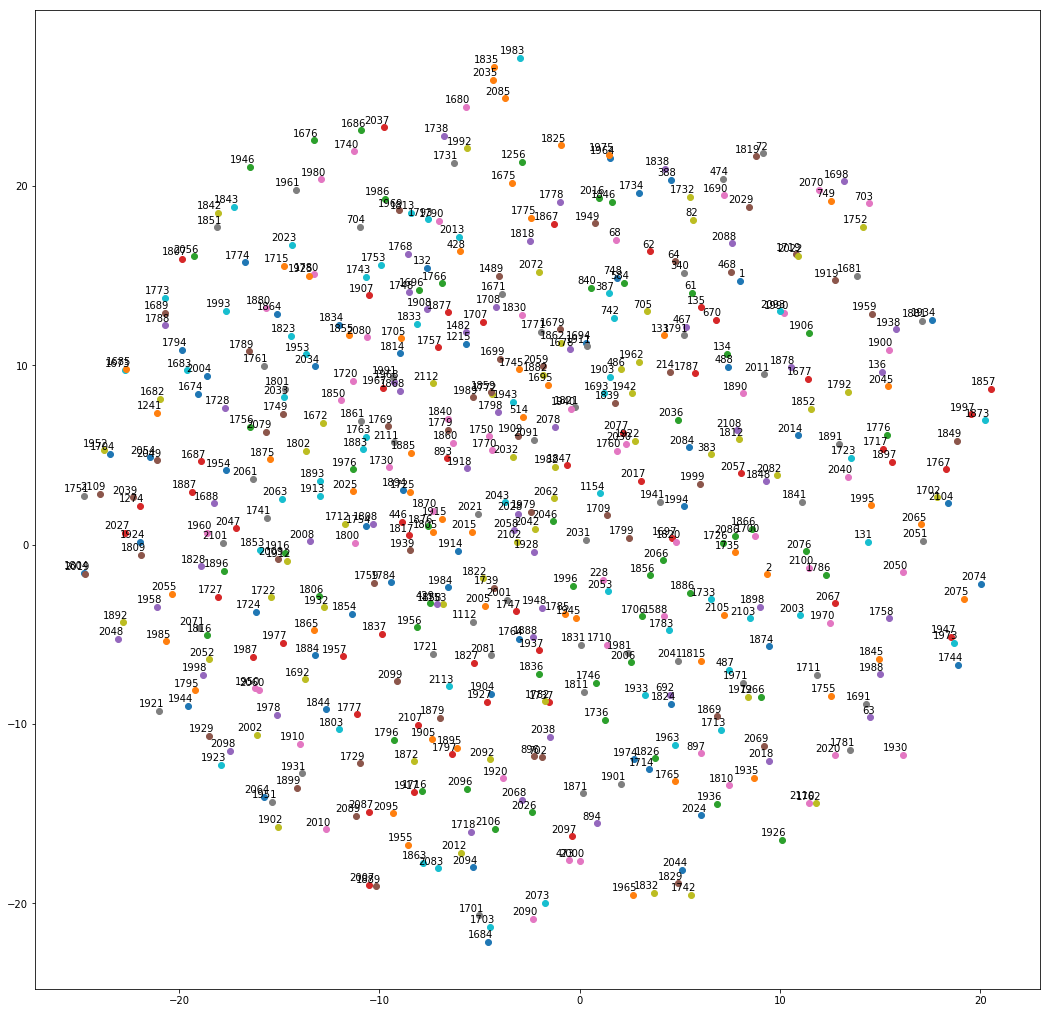

In [28]:
%matplotlib inline

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(docs_embeddings[:plot_only,:])
labels = list(train_corpus.document_from_idx[i] for i in range(plot_only))

plt.figure(figsize=(18, 18))  #in inches
for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

plt.show()